# TP4 - Grupo 20
###  Dezembro, 4, 2024

Afonso Martins Campos Fernandes - A102940

Luís Filipe Pinheiro Silva - A105530

## ABS - Anti-Lock Braking System

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    

- A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.

- A componente contínua  do autómato usa variáveis contínuas $V,v$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo.

- Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.

Fazer:
1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos. 
        Os “switchs” (“jumps”) são uma  componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.
2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
    1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
    2. “a velocidade $V$ diminui sempre com o tempo”.
3. Construa o FOTS que que descreve a discretização do  modelo  que definiu em a. e codifique em SMT’s
4. Codifique a verificação das propriedades temporais que definiu em b.


![](https://paper-attachments.dropboxusercontent.com/s_C5426E33053EA04D1E3446B871CC8485C43045FF7CAAA1FC86A9B3A8E09058F9_1574702123197_Documento.png)
 
Equações de Fluxo: <br>
1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas.<br><br>
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.<br><br>
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.<br><br>
4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.<br><br>
5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,<br>     $\begin{array}{rcl} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$   <br><br>e , no modo `Blocked`,  a dinâmica do sistema é  regida por<br>        $(V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,)$<br><br>
6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau\,$segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem forçar esta condição.<br><br>
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.


## Alínea a)

Utilizamos o matplotlib.pyplot e o networkx para desenhar o autómato híbrido que descreve o sistema ABS.

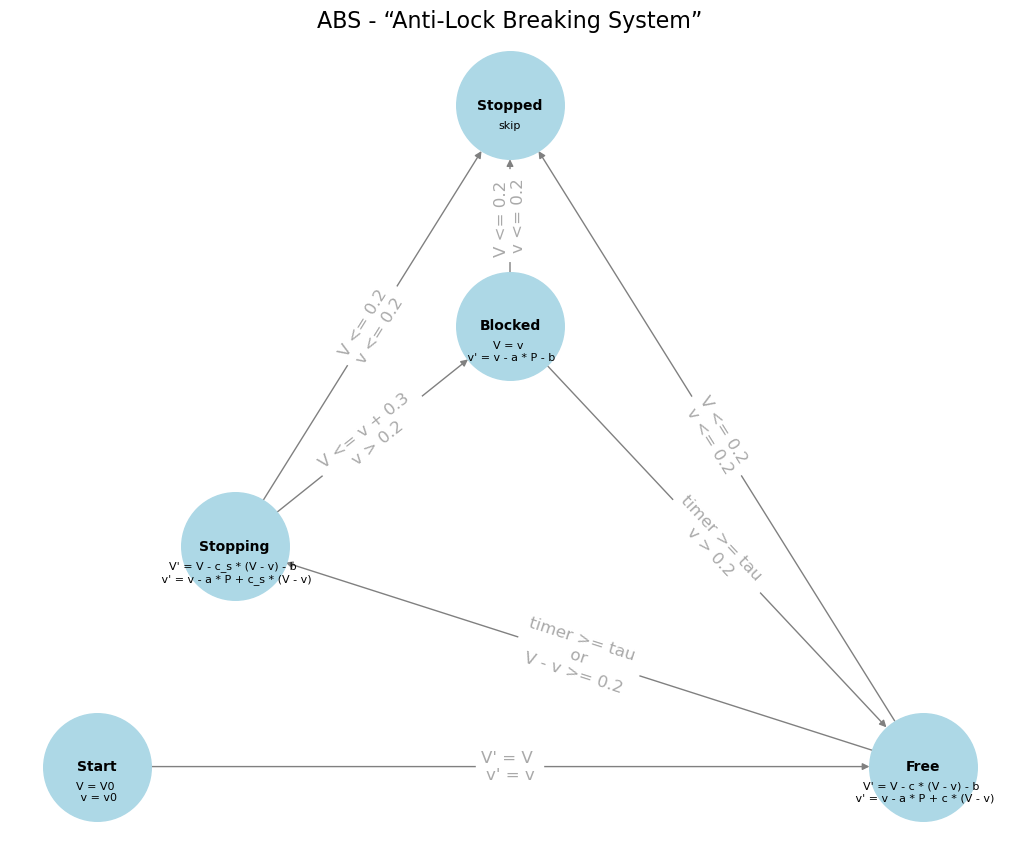

In [69]:
import matplotlib.pyplot as plt
import networkx as nx

# Criação do grafo usando NetworkX
G = nx.DiGraph()

# Adicionando nós
G.add_node('Start', annotation="V = V0 \n v = v0")
G.add_node('Free', annotation="V' = V - c * (V - v) - b \n v' = v - a * P + c * (V - v)")
G.add_node('Stopping', annotation="V' = V - c_s * (V - v) - b \n v' = v - a * P + c_s * (V - v)")
G.add_node('Blocked', annotation="V = v \n v' = v - a * P - b")
G.add_node('Stopped', annotation='skip')

# Adicionando arestas (transições)
G.add_edge('Start', 'Free', label="V' = V \nv' = v")
G.add_edge('Free', 'Stopping', label="timer >= tau \n or \nV - v >= 0.2")
G.add_edge('Free','Stopped', label="V <= 0.2 \nv <= 0.2")
G.add_edge('Stopping', 'Stopped', label="V <= 0.2 \nv <= 0.2")
G.add_edge('Stopping', 'Blocked', label="V <= v + 0.3 \nv > 0.2")
G.add_edge('Blocked', 'Free', label="timer >= tau \nv > 0.2")
G.add_edge('Blocked', 'Stopped', label="V <= 0.2 \nv <= 0.2")

# Posicionamento dos nós (usando um layout circular para clareza)
pos = nx.planar_layout(G)

# Desenhando o grafo sem labels externos
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=6000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')



# Adicionando rótulos nas arestas
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_weight='normal', font_color='darkgray')

annotations = nx.get_node_attributes(G, 'annotation')
for node, annotation in annotations.items():
    xp, yp = pos[node]
    plt.text(xp, yp-0.02, annotation, fontsize=8, ha='center', va='top')


# Exibindo o diagrama
plt.title('ABS - “Anti-Lock Breaking System”', fontsize=16)
plt.axis('off')  # Desativa o eixo para uma melhor visualização
plt.show()

## Alínea c)
Começar por criar as funções das variáveis, do estado inicial e das transições

### Função states(i):

&nbsp;&nbsp;&nbsp;&nbsp;i - valor do traço

In [70]:
from pysmt.shortcuts import *
from z3 import *

#Modes, (START,FREE,STOPPING,BLOCKED,STOPPED) = EnumSort('Modes',('START','FREE','STOPPING','BLOCKED','STOPPED'))

def states(i):
    state = {}

    state['V'] = Real('V'+str(i))
    state['v'] = Real('v'+str(i))
    state['m'] = Const('m'+str(i),Modes)
    state['t'] = Real('t'+str(i))
    state['timer'] = Real('timer'+str(i))

    return state

### Função init(state,v_init):

&nbsp;&nbsp;&nbsp;&nbsp;state - estado atual<br>
&nbsp;&nbsp;&nbsp;&nbsp;v_init - velocidade inicial

In [71]:
def init(state,v_init):
    return And(
        state['V'] == v_init,
        state['v'] == v_init,
        state['m'] == START,
        state['t'] == 0,
        state['timer'] == 0
    )

### Função trans(curr,next):

&nbsp;&nbsp;&nbsp;&nbsp; curr - estado atual<br>
&nbsp;&nbsp;&nbsp;&nbsp; next - próximo estado

In [72]:
c,c_s,a,P,b,tau = 0.15,1,0.002,1300,0.005,0.1 # Variaveis para asfalto seco
# c,c_s,a,P,b,tau = 0.15,1,0.01,1300,0.005,0.1 # Variaveis para asfalto molhado

def trans(curr,prox):

    t0 = And(prox['V'] == curr['v'], #Transição do Start para o Free
             prox['v'] == curr['v'],
             prox['m'] == FREE,
             curr['m'] == START,
             prox['t'] == curr['t'],
             prox['timer'] == 0,
             curr['timer'] == 0
             )
    
    t1 = And(prox['V'] == curr['V'] - (c*(curr['V'] - curr['v']) - b), #Transição do Free para o Free
             prox['v'] == curr['v'] - (a*P + c*(curr['V'] - curr['v'])),
             prox['m'] == FREE,
             curr['m'] == FREE,
             prox['t'] == curr['t'] + 0.1,
             prox['timer'] == curr['timer'] + 0.1,
             prox['timer'] <= tau,
             curr['V'] > 0.2
             )
    
    t2 = And(prox['V'] == curr['V'], #Transição do Free para o Stopping
             prox['v'] == curr['v'],
             prox['m'] == STOPPING,
             curr['m'] == FREE,
             prox['t'] == curr['t'],
             prox['timer'] == 0,
             Or(
                 curr['timer'] >= tau,
                 curr['V'] - curr['v'] >= 0.2
             ))

    t3 = And(prox['V'] == curr['V'] - c_s*(curr['V'] - curr['v']) - b, # Transição do Stopping para o Stopping
             prox['v'] == curr['v'] - a*P + c_s*(curr['V'] - curr['v']),
             prox['m'] == STOPPING,
             curr['m'] == STOPPING,
             prox['t'] == curr['t'] + 0.1,
             prox['timer'] == curr['timer'],
             curr['V'] > curr['v'] + 0.3
             )
    
    t4 = And(prox['V'] == 0, #Transição do Stopping para o Stopped
             prox['v'] == 0,
             prox['m'] == STOPPED,
             curr['m'] == STOPPING,
             prox['t'] == curr['t'],
             prox['timer'] == 0,
             curr['V'] <= 0.2,
             curr['v'] <= 0.2
             )
    
    t5 = And(prox['V'] == curr['V'], #Transição do Stopping para o Blocked
             prox['v'] == curr['v'],
             prox['m'] == BLOCKED,
             curr['m'] == STOPPING,
             prox['t'] == curr['t'],
             prox['timer'] == 0,
             curr['V'] <= curr['v'] + 0.3,
             curr['v'] > 0.2
             )
    
    t6 = And(prox['V'] == curr['v'], #Transição do Blocked para o Blocked
             prox['v'] == curr['v']  - a*P - b,
             prox['m'] == BLOCKED,
             curr['m'] == BLOCKED,
             prox['t'] == curr['t'] + 0.1,
             prox['timer'] == curr['timer'] + 0.1,
             prox['timer'] <= tau
             )
    
    t7 = And(prox['V'] == curr['V'], #Transição do Blocked para o Free
             prox['v'] == curr['v'],
             prox['m'] == FREE,
             curr['m'] == BLOCKED,
             prox['t'] == curr['t'],
             prox['timer'] == 0,
             curr['timer'] >= tau,
             curr['v'] > 0.2
             )
    
    t8 = And(prox['V'] == 0, #Transição do Blocked para o Stoopped
             prox['v'] == 0,
             prox['m'] == STOPPED,
             curr['m'] == BLOCKED,
             prox['t'] == curr['t'],
             prox['timer'] == 0,
             curr['v'] <= 0.2,
             curr['V'] <= 0.2
             )
    
    t9 = And(prox['V'] == curr['V'], # Transição do Stopped para o Stopped
             prox['v'] == curr['v'],
             prox['m'] == STOPPED,
             curr['m'] == STOPPED,
             prox['t'] == curr['t'] + 0.1,
             prox['timer'] == curr['timer']
             )
    
    t10 = And(prox['V'] == 0, #Transição do Free para o Stoopped
              prox['v'] == 0,
              prox['m'] == STOPPED,
              curr['m'] == FREE,
              prox['t'] == curr['t'],
              prox['timer'] == 0,
              curr['v'] <= 0.2,
              curr['V'] <= 0.2
              )
    
    return Or(t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10)

def frac_para_dec(x):
    return float(x.numerator_as_long())/float(x.denominator_as_long())

def gera_fots(init,trans,k,v_init):

    solver = Solver()

    estados = [states(i) for i in range(k)]

    solver.add(init(estados[0],v_init))

    for i in range(k-1):
        solver.add(trans(estados[i],estados[i+1]))

    check = solver.check()
    
    if check == sat:
        print("Is solvable")
        m = solver.model()
        T  = [frac_para_dec(m[estados[i]["t"]] ) for i in range(k)]
        VV = [frac_para_dec(m[estados[i]["V"]]) for i in range(k)]
        VR = [frac_para_dec(m[estados[i]["v"]]) for i in range(k)]

        for i in range(k):
            print("Passo:", i)
            for v in estados[i]:
                res = m[estados[i][v]]
                 
                if res.sort() != RealSort():
                    print(v, '=', res)
                else:
                    print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
    else:
        print("Not solvable")

gera_fots(init,trans,90,40)

Is solvable
Passo: 0
V = 40.0
v = 40.0
m = START
t = 0.0
timer = 0.0
Passo: 1
V = 40.0
v = 40.0
m = FREE
t = 0.0
timer = 0.0
Passo: 2
V = 39.995
v = 37.4
m = FREE
t = 0.1
timer = 0.1
Passo: 3
V = 39.995
v = 37.4
m = STOPPING
t = 0.1
timer = 0.0
Passo: 4
V = 37.395
v = 37.395
m = STOPPING
t = 0.2
timer = 0.0
Passo: 5
V = 37.395
v = 37.395
m = BLOCKED
t = 0.2
timer = 0.0
Passo: 6
V = 37.395
v = 34.79
m = BLOCKED
t = 0.3
timer = 0.1
Passo: 7
V = 37.395
v = 34.79
m = FREE
t = 0.3
timer = 0.0
Passo: 8
V = 36.99925
v = 32.58075
m = FREE
t = 0.4
timer = 0.1
Passo: 9
V = 36.99925
v = 32.58075
m = STOPPING
t = 0.4
timer = 0.0
Passo: 10
V = 32.57575
v = 34.39925
m = STOPPING
t = 0.5
timer = 0.0
Passo: 11
V = 32.57575
v = 34.39925
m = BLOCKED
t = 0.5
timer = 0.0
Passo: 12
V = 34.39925
v = 31.79425
m = BLOCKED
t = 0.6
timer = 0.1
Passo: 13
V = 34.39925
v = 31.79425
m = FREE
t = 0.6
timer = 0.0
Passo: 14
V = 34.39925
v = 31.79425
m = STOPPING
t = 0.6
timer = 0.0
Passo: 15
V = 31.78925
v = 31.79925


## Alínea b)
Modelar em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema.

In [73]:
t = 4 # t segundos

def imobiliza_em_t(state):
    return Implies(state['t'] >= t,state['m'] == STOPPED)

def velocidade_diminui_sempre(curr,prox):
    return Implies(curr['t'] < prox['t'], curr['V'] > prox['V'])

## Alínea d)